<a href="https://colab.research.google.com/github/Jacofeldman/Metodos1_JacoboFeldman/blob/main/Parcial3/Higgs_boson_discovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install emcee
!pip install corner

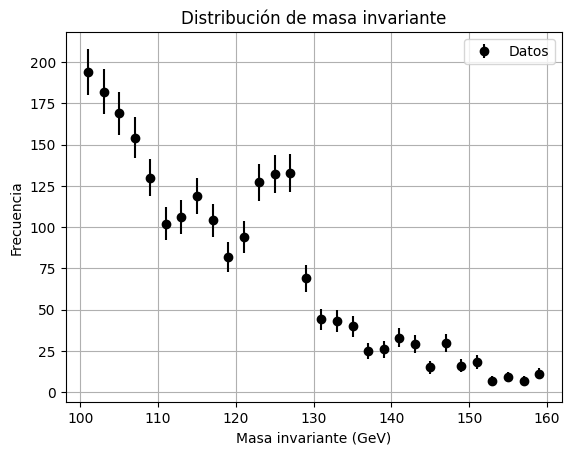

Parámetro α para la hipótesis nula: 17.61888053628762


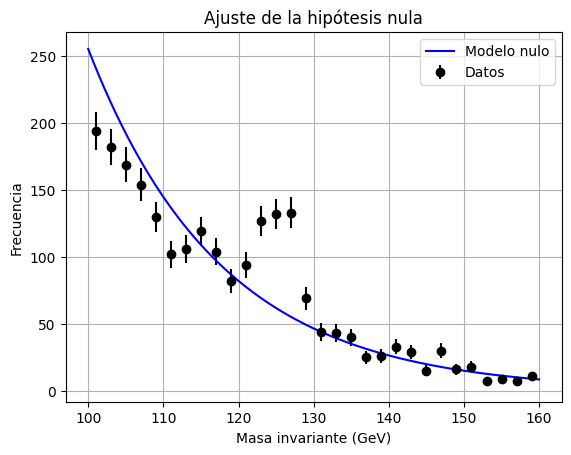

Parámetros de la hipótesis alternativa: A=0.14208932232390514, μ=125.19845517047781, σ=2.7749947051475505, α=16.36446636167997


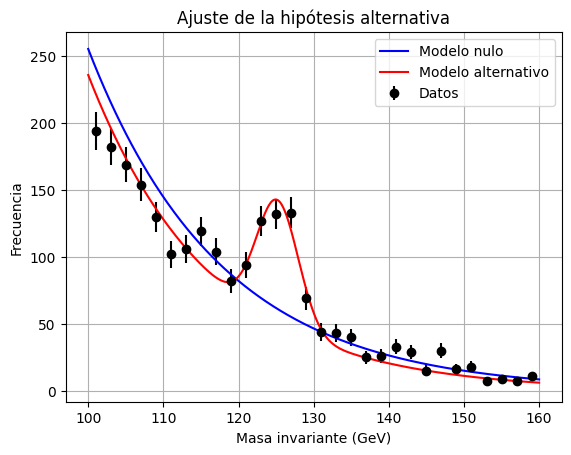

Número de desviaciones estándar (nσ): 15.2070782884126
Tiempo de vida de la partícula: 2.2829299059298736e-14 s


100%|██████████| 2000/2000 [02:33<00:00, 13.03it/s]


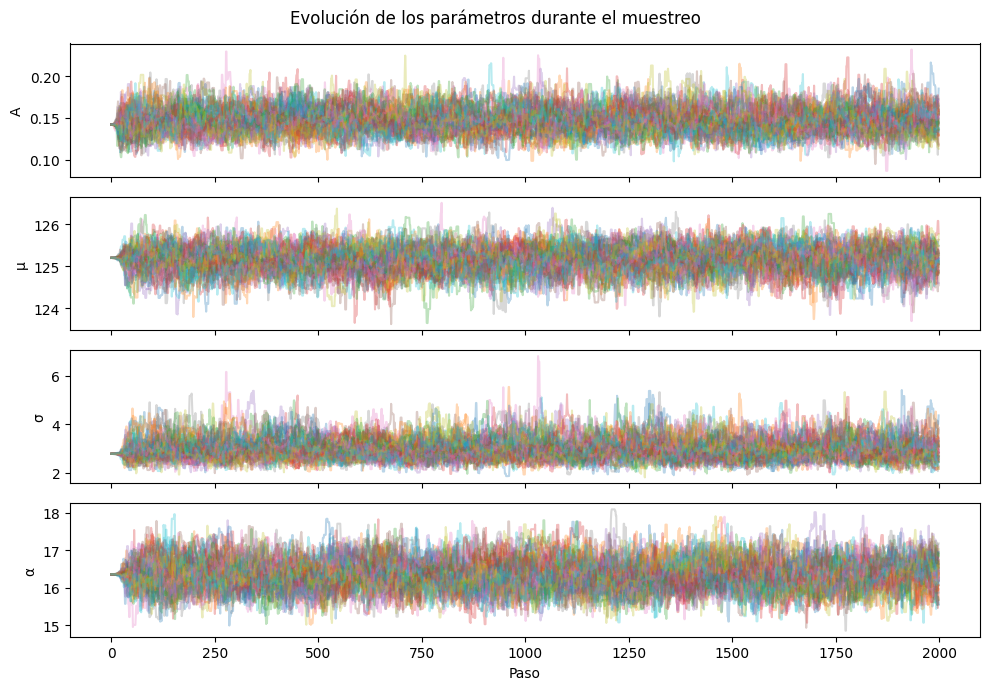

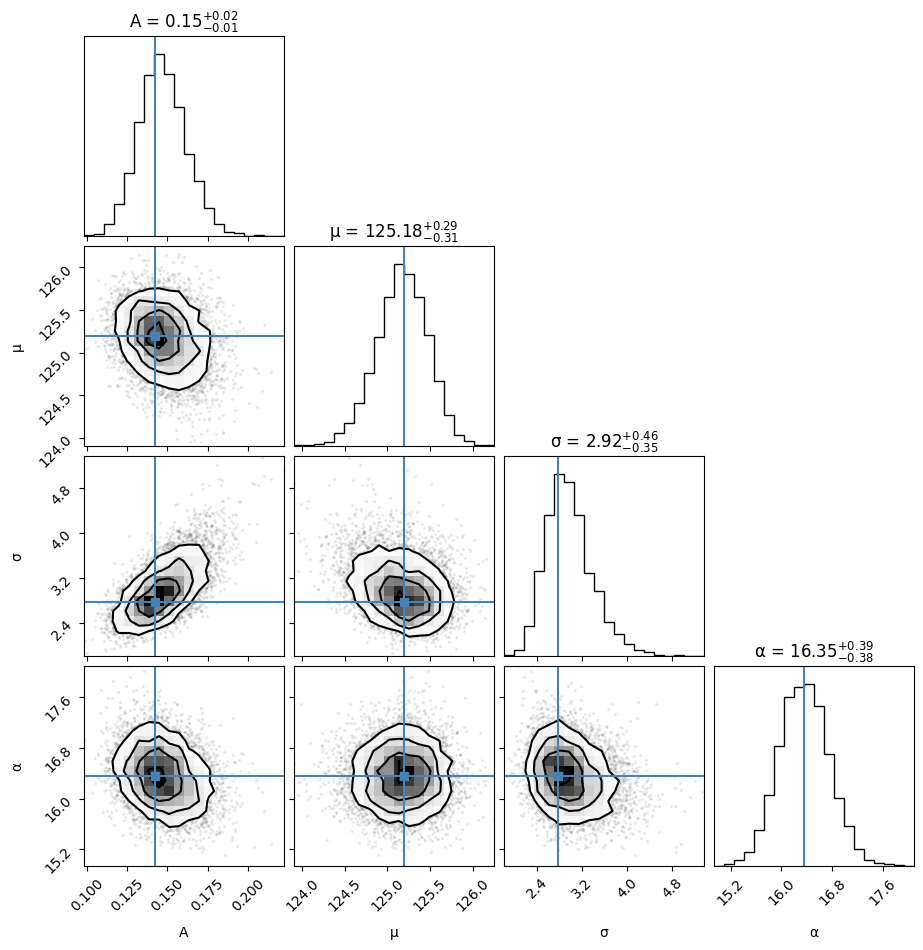

Error porcentual de la masa: 0.24%


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import emcee
import corner

# Descargar y leer datos
url = "https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/HiggsFitting.csv"
data = pd.read_csv(url)
x = data['Higgs']

# (b) Histograma
bins = np.linspace(100, 160, 31)
hist, edges = np.histogram(x, bins=bins)
bin_centers = 0.5 * (edges[:-1] + edges[1:])
errors = np.sqrt(hist)

plt.errorbar(bin_centers, hist, yerr=errors, fmt='o', label="Datos", color="black")
plt.xlabel("Masa invariante (GeV)")
plt.ylabel("Frecuencia")
plt.title("Distribución de masa invariante")
plt.grid()
plt.legend()
plt.show()

# (c) Modelo de hipótesis nula (ruido exponencial)
def null_model_likelihood(alpha, x):
    return (1 / alpha) * np.exp(-(x - 100) / alpha)

# (d) Función de minimización para la hipótesis nula
def negative_log_likelihood_null(alpha, x):
    L = null_model_likelihood(alpha, x)
    return -np.sum(np.log(L))

# (e) Optimización para la hipótesis nula
result_null = minimize(
    negative_log_likelihood_null,
    x0=[10],
    args=(x,),
    bounds=[(0, 50)]
)
alpha_null = result_null.x[0]
print(f"Parámetro α para la hipótesis nula: {alpha_null}")

# Gráfico del modelo ajustado
plt.errorbar(bin_centers, hist, yerr=errors, fmt='o', label="Datos", color="black")
x_model = np.linspace(100, 160, 500)
y_null = null_model_likelihood(alpha_null, x_model) * len(x) * (bins[1] - bins[0])
plt.plot(x_model, y_null, label="Modelo nulo", color="blue")
plt.legend()
plt.xlabel("Masa invariante (GeV)")
plt.ylabel("Frecuencia")
plt.title("Ajuste de la hipótesis nula")
plt.grid()
plt.show()

# (g) Modelo de hipótesis alternativa
def alt_model_likelihood(params, x):
    A, mu, sigma, alpha = params
    signal = A * (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    background = (1 - A) * (1 / alpha) * np.exp(-(x - 100) / alpha)
    return signal + background

# (h) Función de minimización para la hipótesis alternativa
def negative_log_likelihood_alt(params, x):
    L = alt_model_likelihood(params, x)
    return -np.sum(np.log(L))

# (i) Optimización para la hipótesis alternativa
initial_guess = [0.1, 125, 2, alpha_null]
bounds = [(0, 1), (100, 160), (0.1, 10), (1, 50)]
result_alt = minimize(
    negative_log_likelihood_alt,
    x0=initial_guess,
    args=(x,),
    bounds=bounds
)
A, mu, sigma, alpha_alt = result_alt.x
print(f"Parámetros de la hipótesis alternativa: A={A}, μ={mu}, σ={sigma}, α={alpha_alt}")

# Gráfico del ajuste completo
y_alt = alt_model_likelihood([A, mu, sigma, alpha_alt], x_model) * len(x) * (bins[1] - bins[0])
plt.errorbar(bin_centers, hist, yerr=errors, fmt='o', label="Datos", color="black")
plt.plot(x_model, y_null, label="Modelo nulo", color="blue")
plt.plot(x_model, y_alt, label="Modelo alternativo", color="red")
plt.legend()
plt.xlabel("Masa invariante (GeV)")
plt.ylabel("Frecuencia")
plt.title("Ajuste de la hipótesis alternativa")
plt.grid()
plt.show()

# (l) Cálculo del número de desviaciones estándar
lnL_null = -negative_log_likelihood_null(alpha_null, x)
lnL_alt = -negative_log_likelihood_alt([A, mu, sigma, alpha_alt], x)
n_sigma = np.sqrt(-2 * (lnL_null - lnL_alt))
print(f"Número de desviaciones estándar (nσ): {n_sigma}")

# (m) Tiempo de vida de la partícula
hbar = 1.015e-23  # J·s
GeV_to_J = 1.60218e-10  # 1 GeV = 1.60218e-10 J
tau = hbar / (sigma * GeV_to_J)
print(f"Tiempo de vida de la partícula: {tau} s")

# (n) y (o) Muestreo con emcee y visualización del cambio de las variables
def log_prior(params):
    A, mu, sigma, alpha = params
    if 0. < A < 1. and 100. <= mu <= 160. and 0.1 <= sigma <= 10. and 1. <= alpha <= 50.:
        return 0.0
    return -np.inf

def log_likelihood(params, x):
    return -negative_log_likelihood_alt(params, x)

def log_posterior(params, x):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x)

# Configuración de emcee
n_walkers = 50  # Número de caminantes
n_steps = 2000  # Número de pasos
ndim = 4        # Número de parámetros

# Inicialización cercana al resultado del ajuste
initial_pos = result_alt.x + 1e-4 * np.random.randn(n_walkers, ndim)

# Muestreo con emcee
sampler = emcee.EnsembleSampler(n_walkers, ndim, log_posterior, args=[x])
sampler.run_mcmc(initial_pos, n_steps, progress=True)

# Extraer la cadena completa
samples = sampler.get_chain()  # Forma: (n_steps, n_walkers, ndim)

# Graficar la evolución de cada parámetro
param_names = ["A", "μ", "σ", "α"]
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
for i in range(ndim):
    ax = axes[i]
    for walker in range(n_walkers):
        ax.plot(samples[:, walker, i], alpha=0.3)
    ax.set_ylabel(param_names[i])
axes[-1].set_xlabel("Paso")
plt.suptitle("Evolución de los parámetros durante el muestreo")
plt.tight_layout()
plt.show()

# (o) Corner plot de las distribuciones marginales
samples_flat = sampler.get_chain(discard=500, thin=10, flat=True)  # Cadena ajustada
fig = corner.corner(
    samples_flat,
    labels=param_names,
    truths=[A, mu, sigma, alpha_alt],
    show_titles=True
)
plt.show()

# (p) Error porcentual de la masa
mu_samples = samples_flat[:, 1]  # Extraer muestras de μ
mu_std = np.std(mu_samples)  # Desviación estándar de μ
mu_error_percent = (mu_std / mu) * 100
print(f"Error porcentual de la masa: {mu_error_percent:.2f}%")
